In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import ARIMA,seasonal_decompose,adfuller,SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src.datasets.data_ingestion import DataIngestion

from tools.config import load_config
from src.helpers.ts_helper import test_stationary

from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,root_mean_squared_error


# load in data

data = DataIngestion(load_config()).fetch_fred_data()



data.head(10)



/home/nickkats1/Fed-Funds-Forecast/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


,FEDFUNDS,date
0,0.80,1954-07-01
1,1.22,1954-08-01
2,1.07,1954-09-01
3,0.85,1954-10-01
4,0.83,1954-11-01
5,1.28,1954-12-01
6,1.39,1955-01-01
7,1.29,1955-02-01
8,1.35,1955-03-01
9,1.43,1955-04-01


- convert to datetime and set index to date

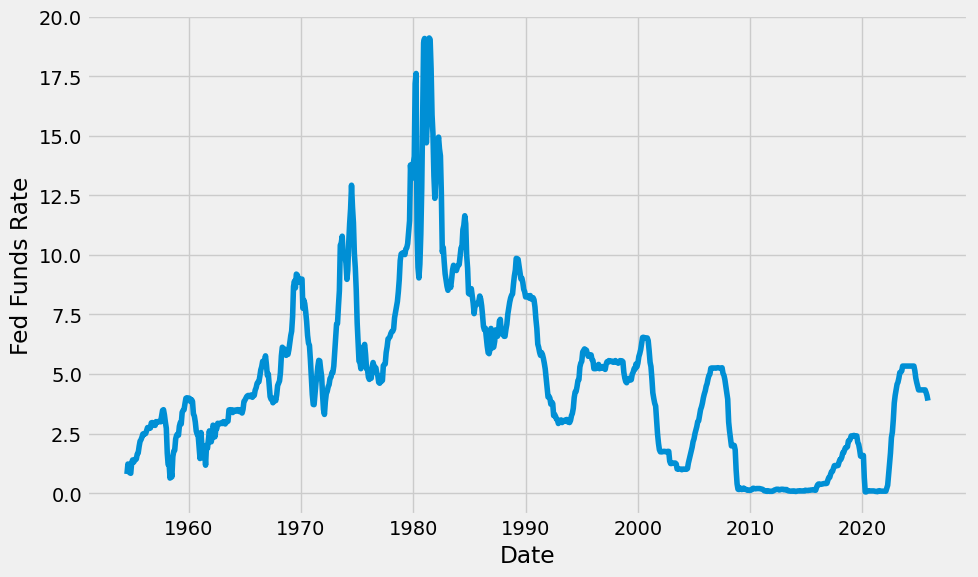

In [2]:
data['date'] = pd.to_datetime(data['date'])

# set index to date
data.set_index("date",inplace=True)

# simple plot
plt.figure(figsize=(10,6))
plt.plot(data)
plt.xlabel("Date")
plt.ylabel("Fed Funds Rate")
plt.tight_layout()
plt.grid(True)
plt.show()

### Adfueller test if stationary

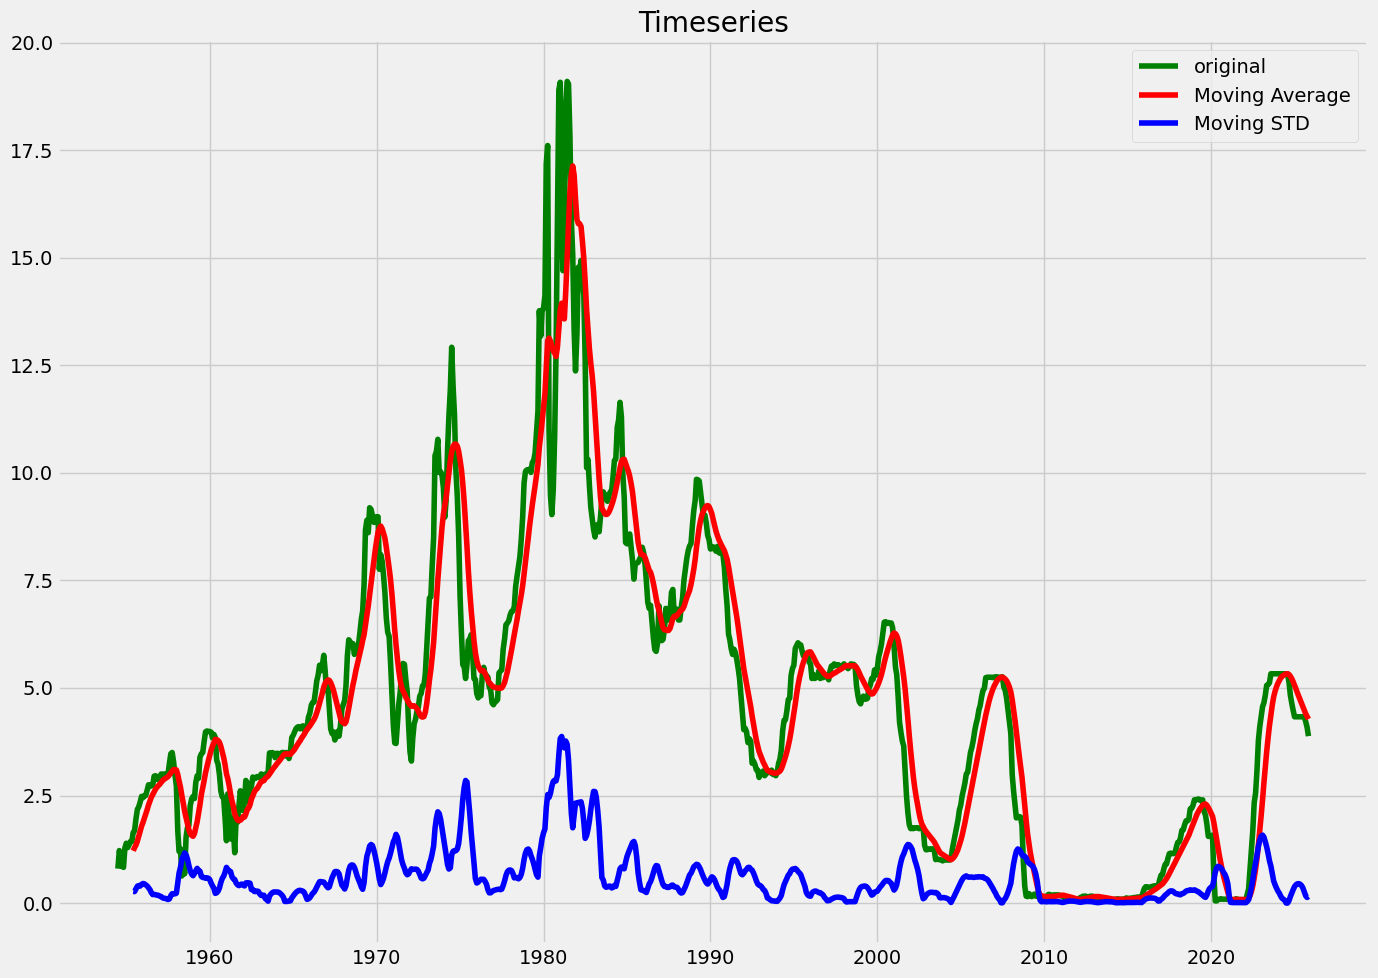


Results from Fueller Tests

Test Statistic                  -2.991685
p-value                          0.035678
'#Lags Used                     17.000000
Number of Observations Used    839.000000
Critical Value (1%)             -3.438168
Critical Value (5%)             -2.864991
Critical Value (10%)            -2.568608
dtype: float64
P-Value
0.035678264860177

Lags Used

17


In [3]:
# test stationary of original series

test_stationary(data)




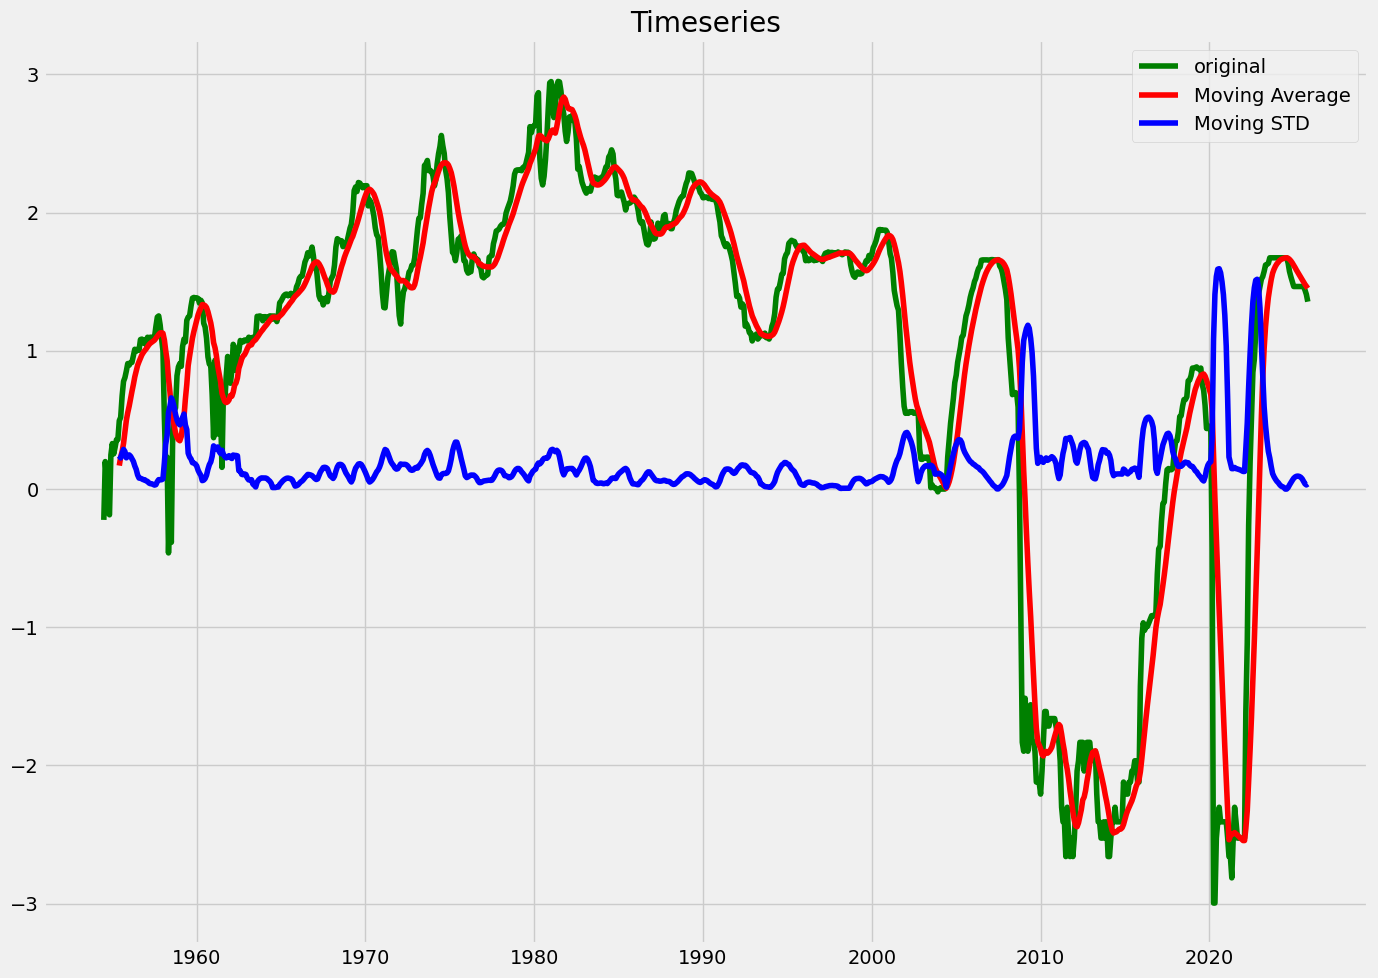


Results from Fueller Tests

Test Statistic                  -2.246856
p-value                          0.189681
'#Lags Used                      1.000000
Number of Observations Used    855.000000
Critical Value (1%)             -3.438021
Critical Value (5%)             -2.864926
Critical Value (10%)            -2.568573
dtype: float64
P-Value
0.18968092541331638

Lags Used

1


In [4]:
# log values

log_df = np.log(data).dropna()

test_stationary(log_df)

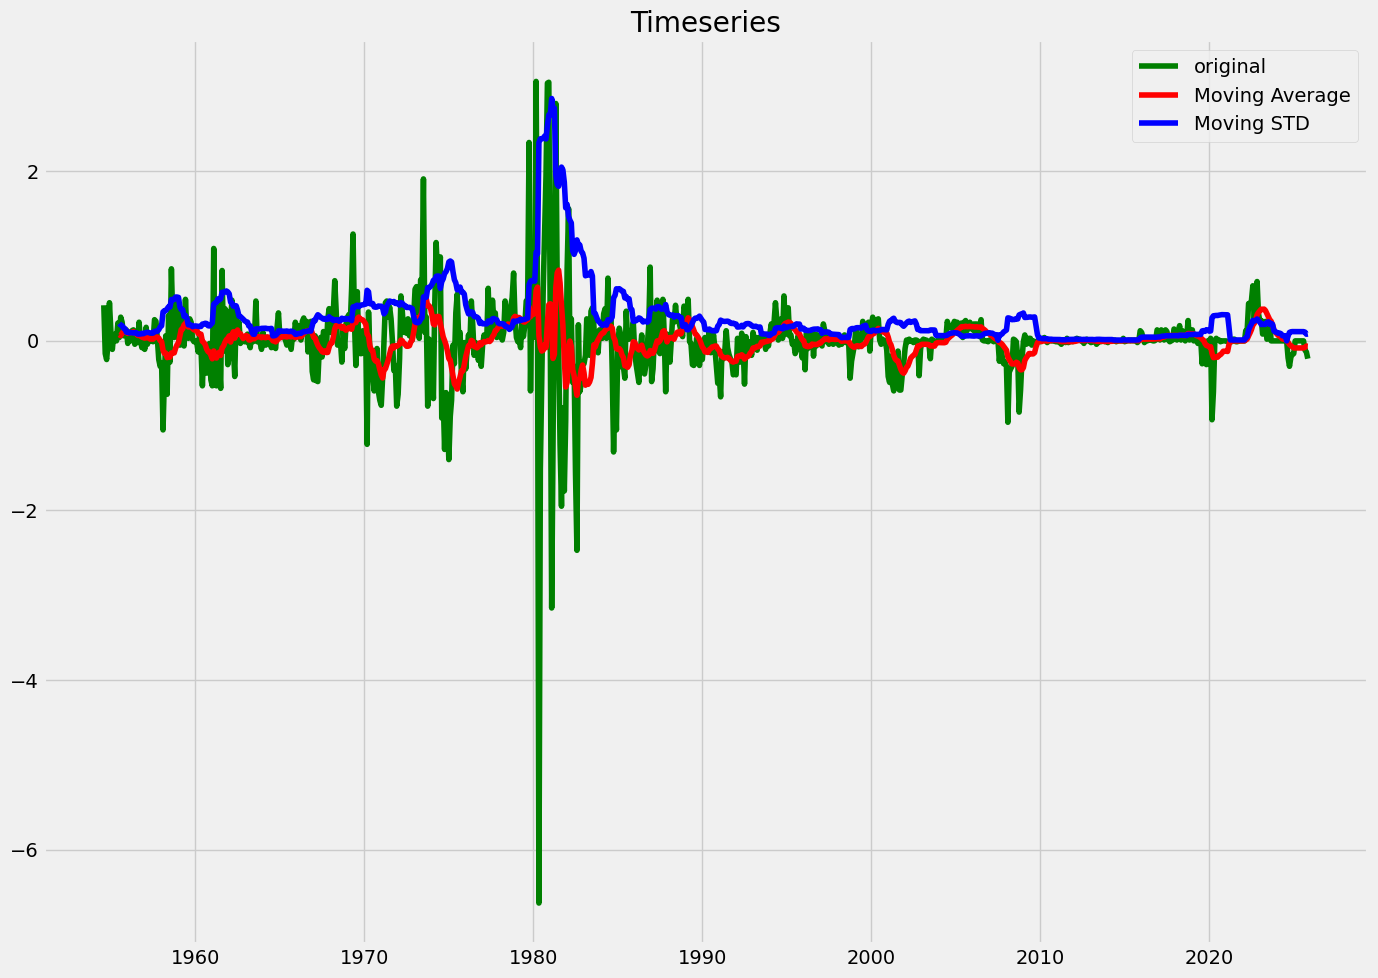


Results from Fueller Tests

Test Statistic                -6.471013e+00
p-value                        1.367176e-08
'#Lags Used                    1.800000e+01
Number of Observations Used    8.370000e+02
Critical Value (1%)           -3.438187e+00
Critical Value (5%)           -2.864999e+00
Critical Value (10%)          -2.568612e+00
dtype: float64
P-Value
1.3671760312355712e-08

Lags Used

18


In [5]:
# first-order differencing

df_diff = data.diff().dropna()
test_stationary(df_diff)

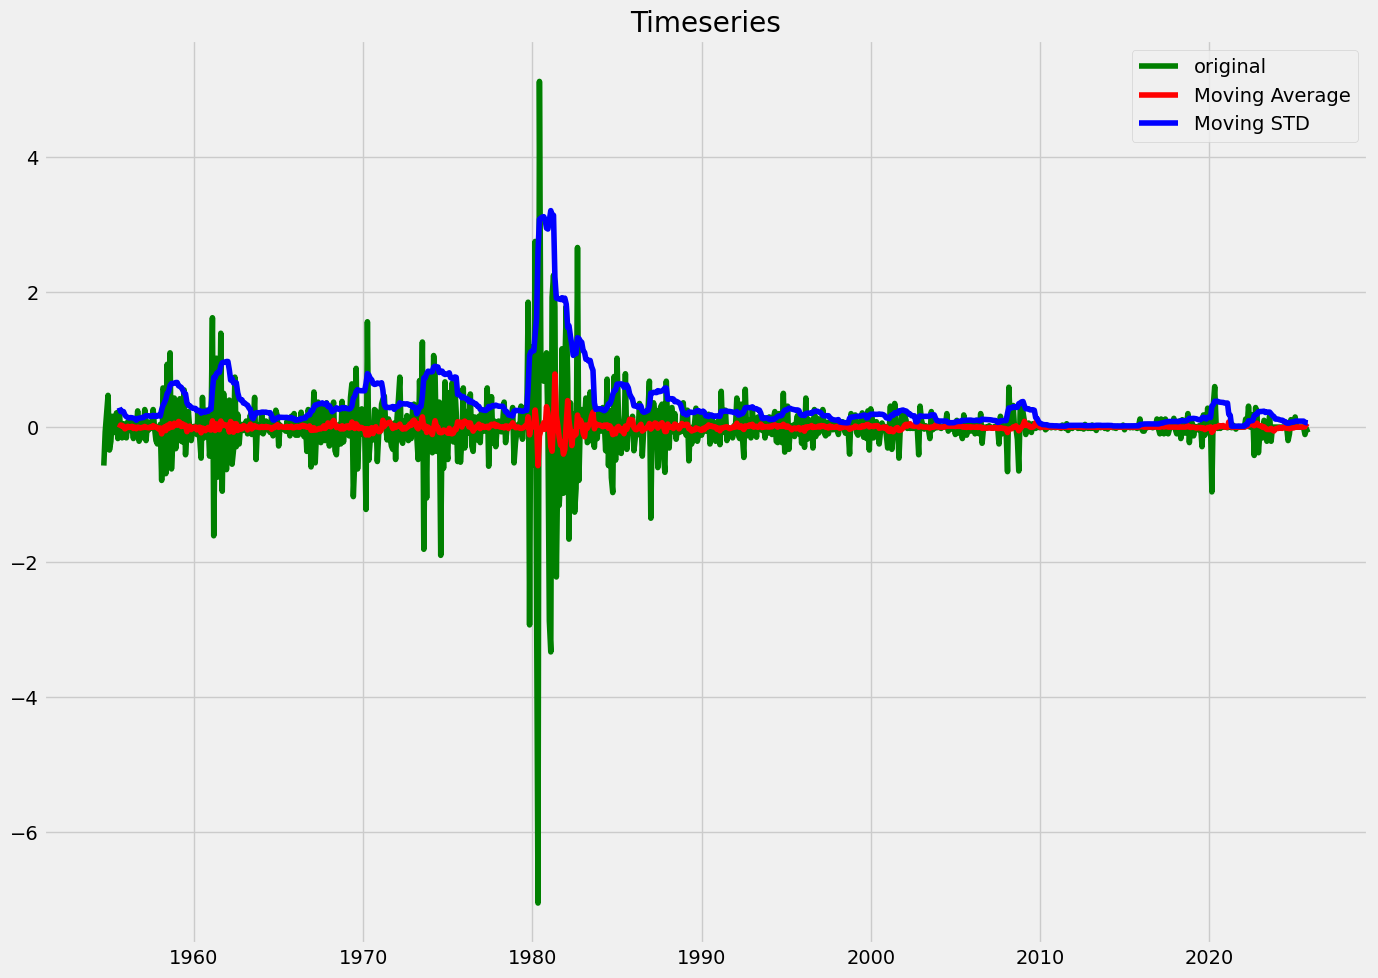


Results from Fueller Tests

Test Statistic                -1.452235e+01
p-value                        5.498067e-27
'#Lags Used                    1.400000e+01
Number of Observations Used    8.400000e+02
Critical Value (1%)           -3.438159e+00
Critical Value (5%)           -2.864987e+00
Critical Value (10%)          -2.568605e+00
dtype: float64
P-Value
5.49806673381452e-27

Lags Used

14


In [6]:
# second-order differencing 

df_diff_diff = data.diff().diff().dropna()
test_stationary(df_diff_diff)

* ACF plots for First and Second-order Differencing.

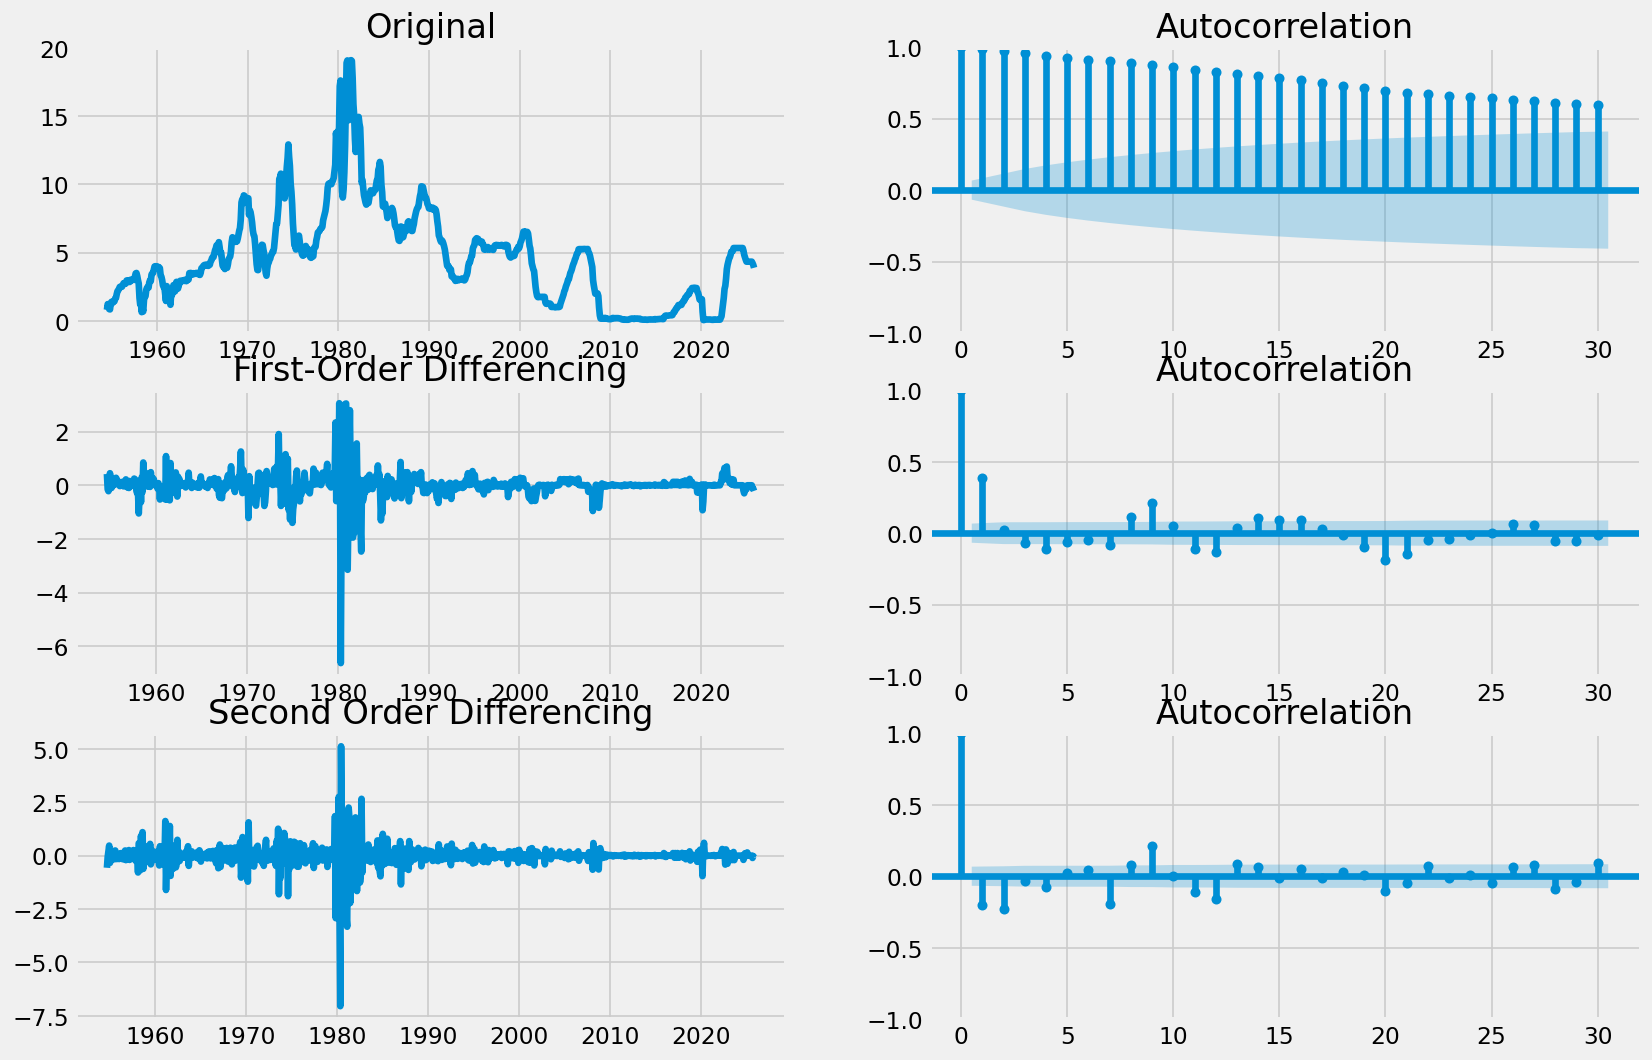

In [7]:
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})

fig,axs = plt.subplots(3,2)
# original data points
axs[0,0].plot(data);axs[0,0].set_title("Original")
plot_acf(data,ax=axs[0,1])

# first-order differencing
axs[1,0].plot(data.diff().dropna());axs[1,0].set_title("First-Order Differencing")
plot_acf(data.diff().dropna(),ax=axs[1,1])

# second-order Differencing
axs[2,0].plot(data.diff().diff().dropna());axs[2,0].set_title("Second Order Differencing")
plot_acf(data.diff().diff().dropna(),ax=axs[2,1])
plt.show()








- PACF plots for first and Second-order Differencing.

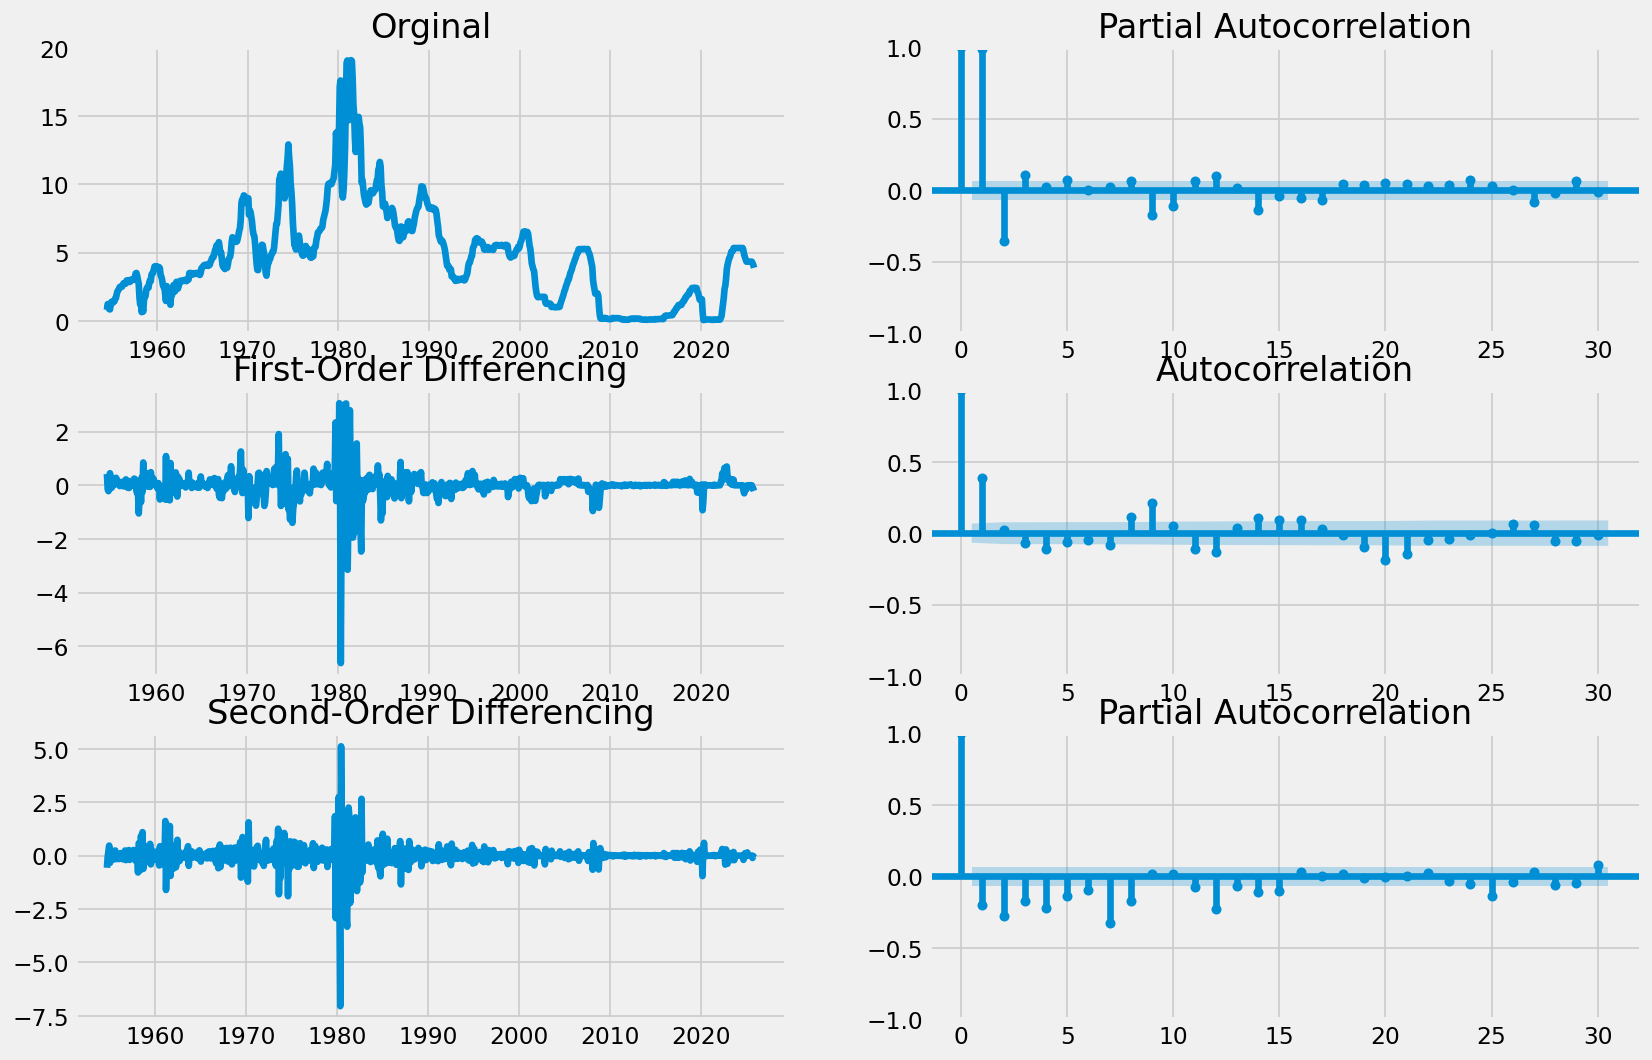

In [8]:

fig,axs = plt.subplots(3,2)
axs[0,0].plot(data);axs[0,0].set_title("Orginal")
plot_pacf(data,ax=axs[0,1])

# first-order differencing
axs[1,0].plot(data.diff().dropna());axs[1,0].set_title("First-Order Differencing")
plot_acf(data.diff().dropna(),ax=axs[1,1])


# Second-Order Differencing
axs[2,0].plot(data.diff().diff().dropna());axs[2,0].set_title("Second-Order Differencing")
plot_pacf(data.diff().diff().dropna(),ax=axs[2,1])
plt.show()

### ARIMA
- Use the results from first-order differencing, second-order differencing, ACF, and pacf to determine best values for ARIMA forecast.

In [9]:
# Order(1,1,1)
results = ARIMA(data,order=(1,1,1))
fitted_results = results.fit()
fitted_results.summary()

/home/nickkats1/Fed-Funds-Forecast/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/nickkats1/Fed-Funds-Forecast/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/nickkats1/Fed-Funds-Forecast/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  857
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -509.307
Date:                Mon, 08 Dec 2025   AIC                           1024.613
Time:                        19:25:27   BIC                           1038.870
Sample:                    07-01-1954   HQIC                          1030.072
                         - 11-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1037      0.035      3.003      0.003       0.036       0.171
ma.L1          0.3439      0.036      9.674      0.000       0.274       0.414
sigma2         0.1924      0.003     64.544      0.000       0.187       0.198
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            126991.99
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                            -3.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        62.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
# ARIMA Order(1,3,2)
results = ARIMA(data,order=(2,3,2))
results_fitted = results.fit()
results_fitted.summary()

/home/nickkats1/Fed-Funds-Forecast/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/nickkats1/Fed-Funds-Forecast/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/nickkats1/Fed-Funds-Forecast/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  857
Model:                 ARIMA(2, 3, 2)   Log Likelihood                -519.406
Date:                Mon, 08 Dec 2025   AIC                           1048.813
Time:                        19:25:30   BIC                           1072.562
Sample:                    07-01-1954   HQIC                          1057.908
                         - 11-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4486      0.014     31.946      0.000       0.421       0.476
ar.L2         -0.1485      0.015     -9.727      0.000      -0.178      -0.119
ma.L1         -1.9952      0.022    -90.268      0.000      -2.039      -1.952
ma.L2          0.9953      0.022     45.354      0.000       0.952       1.038
sigma2         0.1935      0.005     37.986      0.000       0.184       0.204
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            131184.72
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                            -3.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        63.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

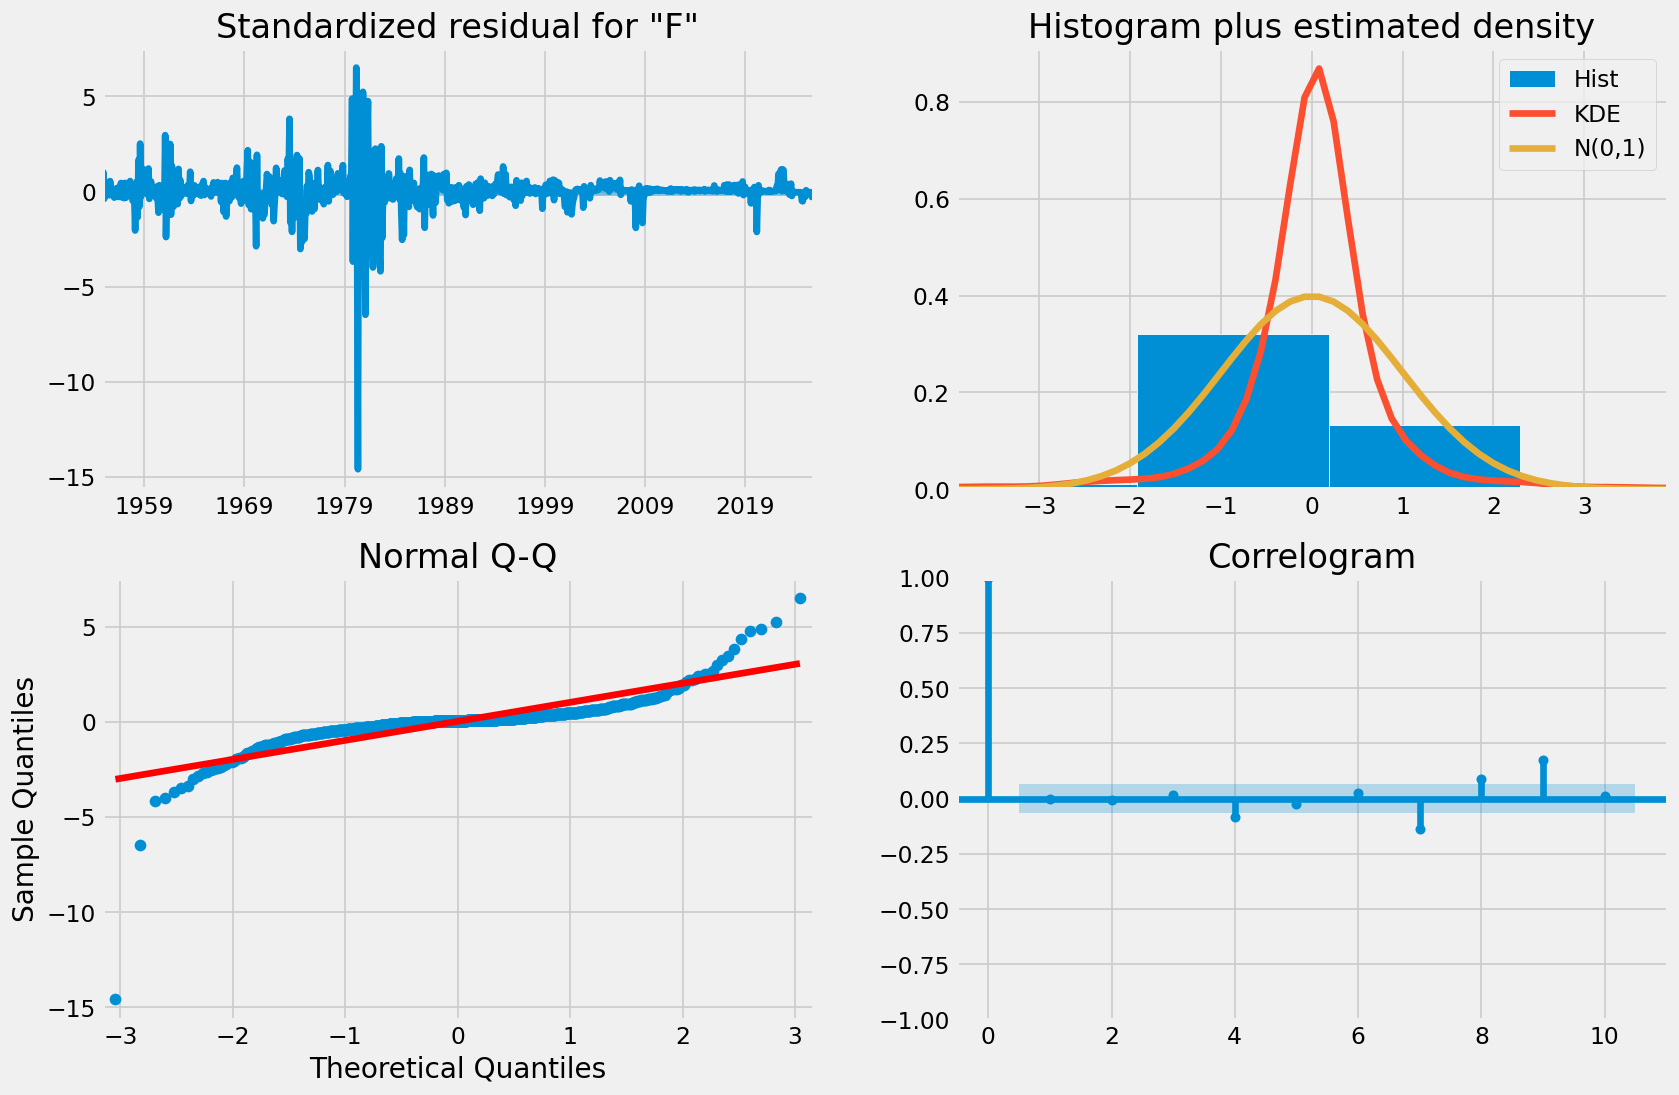

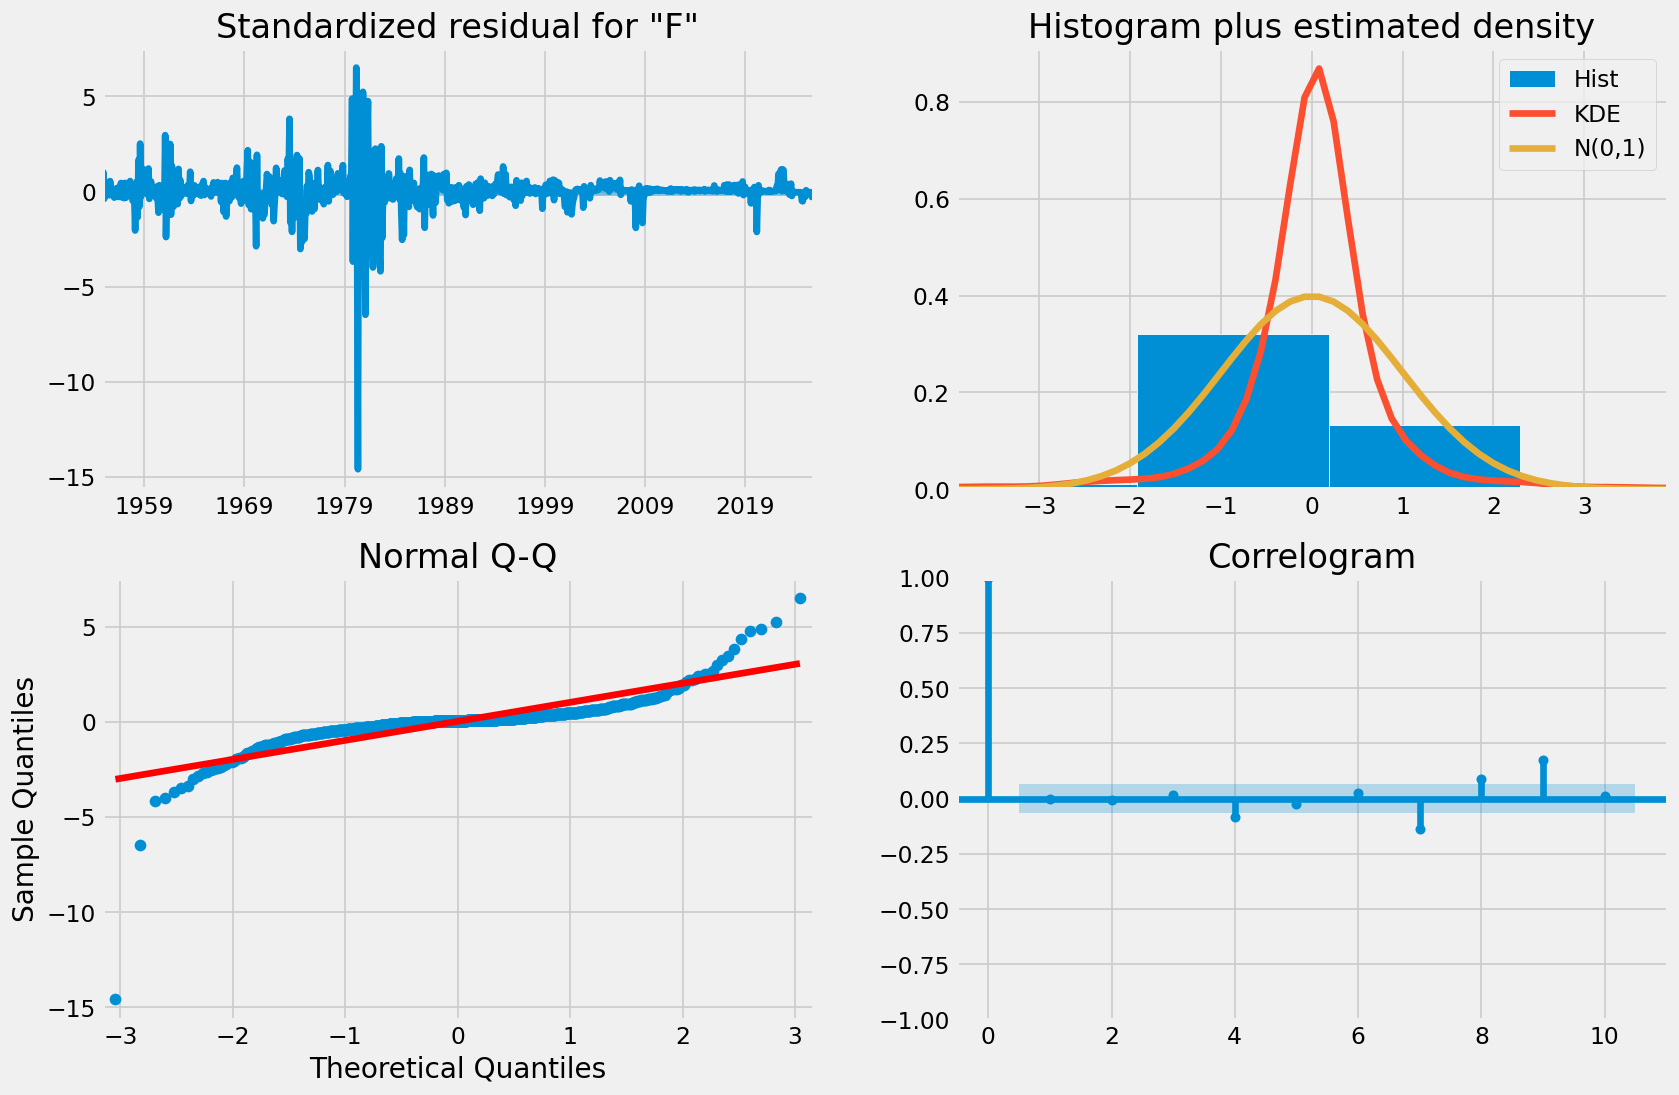

In [11]:
# plot of results
results_fitted.plot_diagnostics()



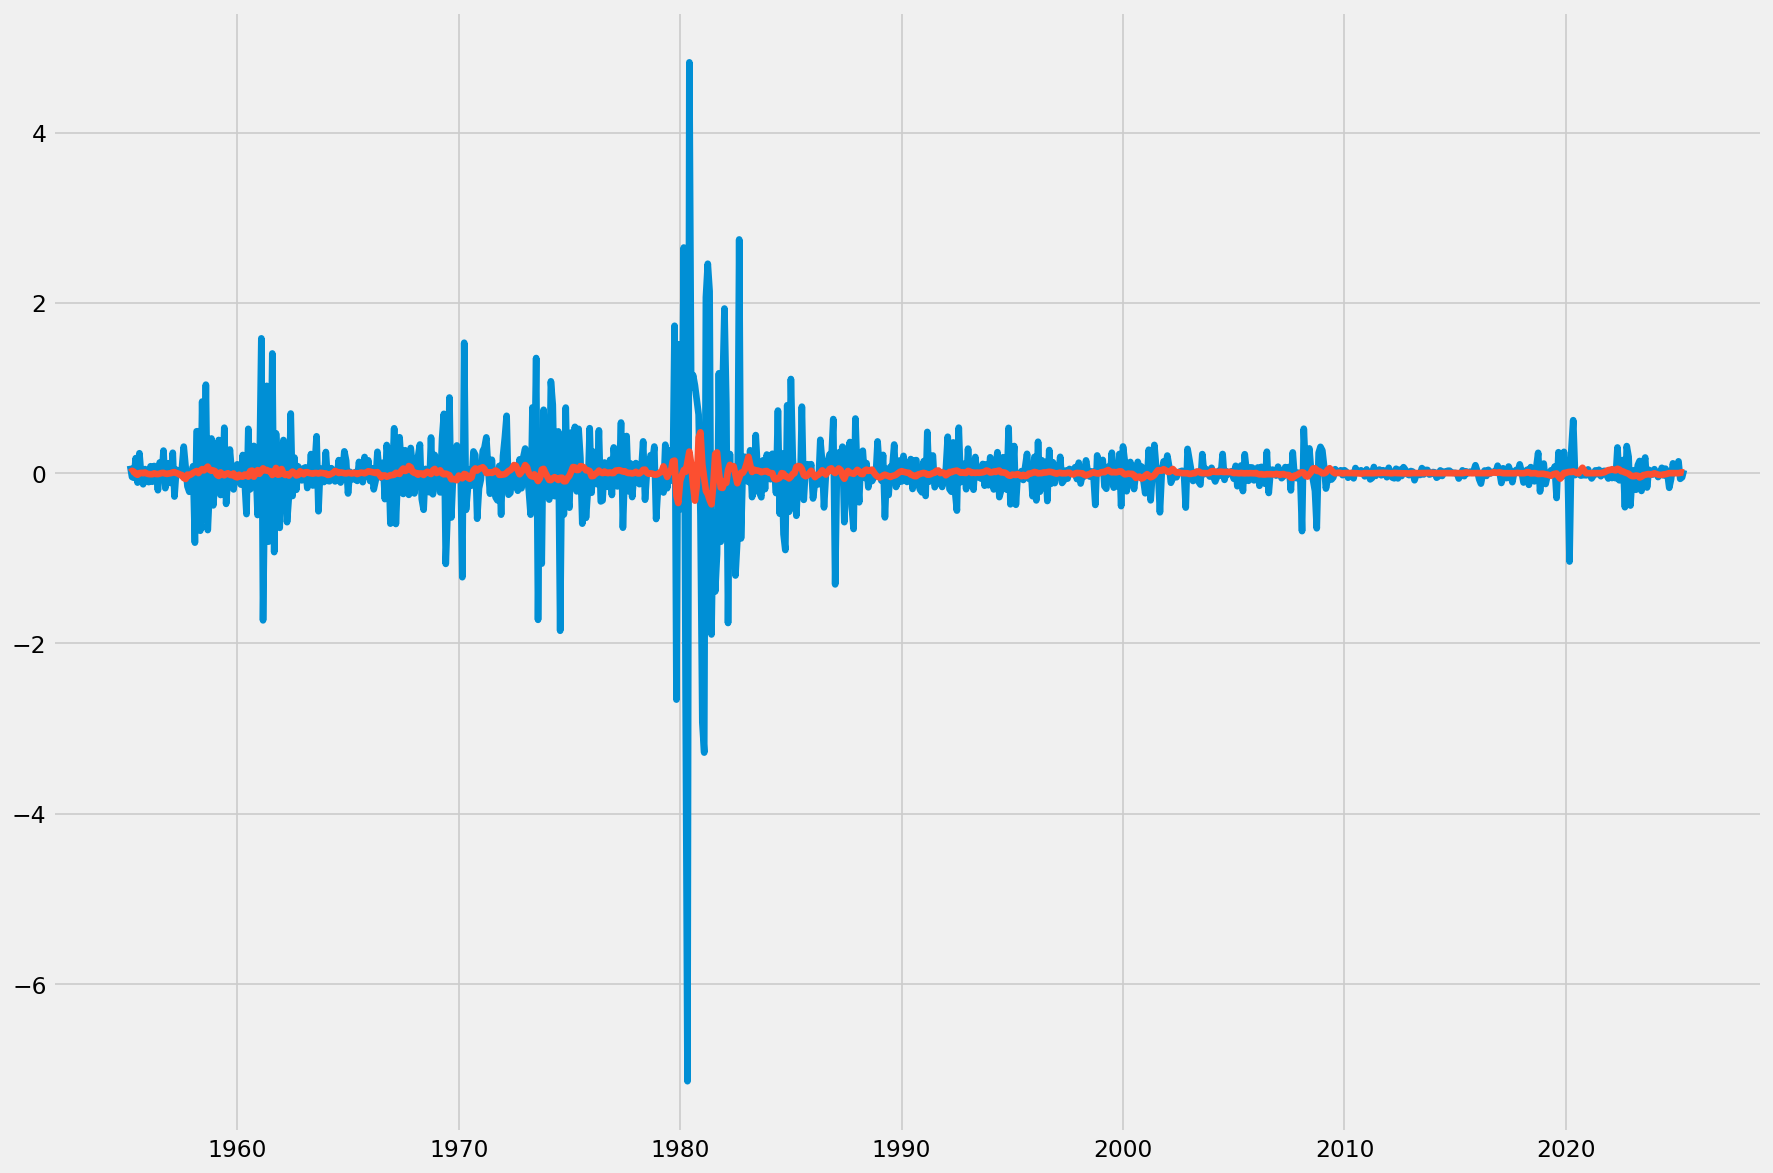

In [12]:
# seasonal decompose

seasonal_decomp = seasonal_decompose(x=df_diff_diff)

resid = seasonal_decomp.resid
trends = seasonal_decomp.trend


plt.figure(figsize=(15,10))
plt.plot(resid)
plt.plot(trends)
plt.tight_layout()
plt.show()


<Axes: xlabel='date'>

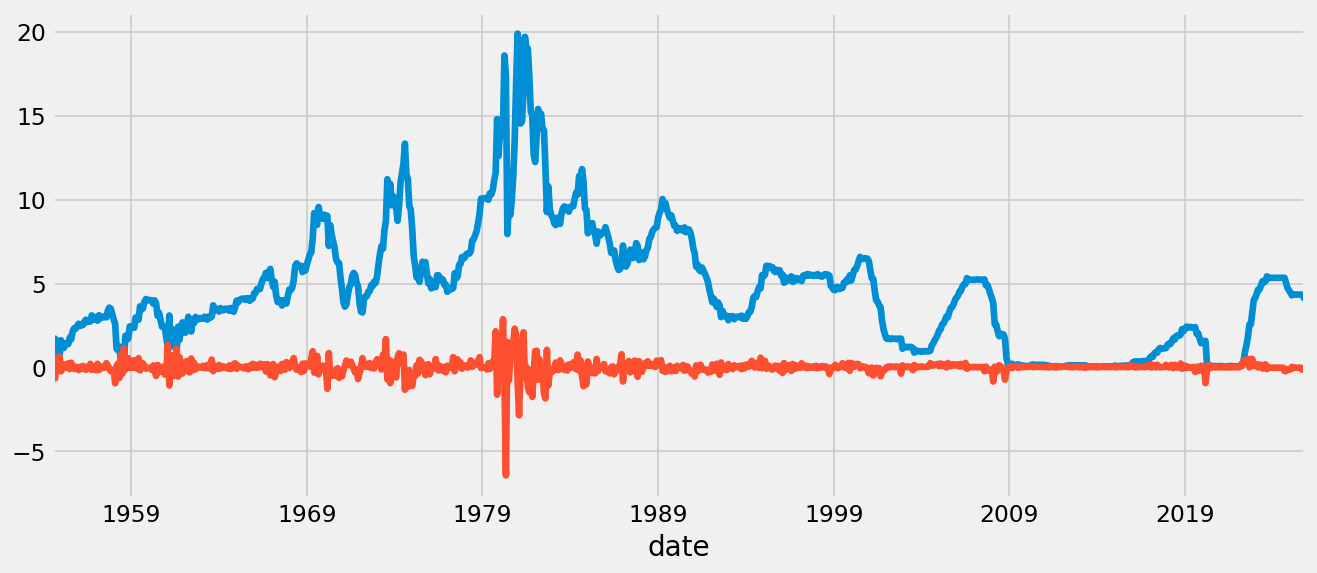

In [13]:
# predictions using ARIMA
result_predict = results_fitted.predict()
results_resid = results_fitted.resid

plt.figure(figsize=(12,5))
result_predict.plot()
results_resid.plot()



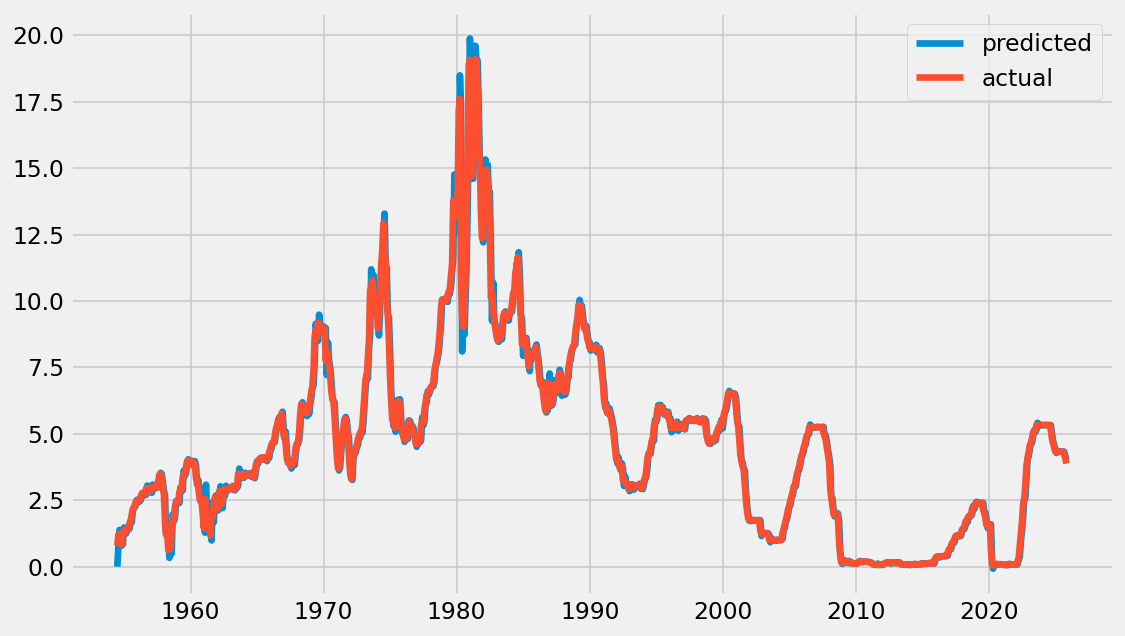

In [14]:
# predicted
data['predicted'] = fitted_results.fittedvalues
forecast = fitted_results.forecast(steps=14)



plt.figure(figsize=(10,6))
plt.plot(data['predicted'],label="predicted")
plt.plot(data['FEDFUNDS'],label="actual")
plt.legend()
plt.show()



predictions_df = pd.DataFrame({
    "predicted": data['predicted'],
    "actual": data['FEDFUNDS'],

})

In [15]:
predictions_df['actual'].tail(20),predictions_df['predicted'].tail(20)

(date
 2024-04-01    5.33
 2024-05-01    5.33
 2024-06-01    5.33
 2024-07-01    5.33
 2024-08-01    5.33
 2024-09-01    5.13
 2024-10-01    4.83
 2024-11-01    4.64
 2024-12-01    4.48
 2025-01-01    4.33
 2025-02-01    4.33
 2025-03-01    4.33
 2025-04-01    4.33
 2025-05-01    4.33
 2025-06-01    4.33
 2025-07-01    4.33
 2025-08-01    4.33
 2025-09-01    4.22
 2025-10-01    4.09
 2025-11-01    3.88
 Name: actual, dtype: float64,
 date
 2024-04-01    5.329951
 2024-05-01    5.330017
 2024-06-01    5.329994
 2024-07-01    5.330002
 2024-08-01    5.329999
 2024-09-01    5.330000
 2024-10-01    5.040481
 2024-11-01    4.726510
 2024-12-01    4.590550
 2025-01-01    4.425392
 2025-02-01    4.281642
 2025-03-01    4.346632
 2025-04-01    4.324280
 2025-05-01    4.331967
 2025-06-01    4.329323
 2025-07-01    4.330233
 2025-08-01    4.329920
 2025-09-01    4.330028
 2025-10-01    4.170755
 2025-11-01    4.048749
 Name: predicted, dtype: float64)

In [16]:
#mape, mae, root_mse
y_pred = predictions_df['predicted']
y_test = predictions_df['actual']
rmse = root_mean_squared_error(y_test,y_pred)
print(f"Root Mean Squared Error: {rmse:.4}")

# MAE
mae = mean_absolute_error(y_test,y_pred)
print(f"Mean Absolute Error: {mae}")

# mape
mape = mean_absolute_percentage_error(y_test,y_pred)
print(F"Mean Average Percentage Error: {mape:.4}")



Root Mean Squared Error: 0.4393
Mean Absolute Error: 0.20987515508282759
Mean Average Percentage Error: 0.07228
